<a href="https://colab.research.google.com/github/rits1995/Semantic-Road-Scene-Segmentation-using-Deep-learning/blob/main/ritesh_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The semantic segmentation task is the process of predicting each pixel in the image to some class, classes could be a person, car, tree, etc. Road scene segmentation has a vast application in the autonomous driving system, nowadays researchers are emphasizing on autonomous vehicles to reduce the human effort of driving, and also to reduce the chances of road accidents caused by human error. Lots of research have been done to segment and classify the objects in the road scene, we humans can easily detect and understand the objects around the road scene, but it is quite a challenging task for any machine. And a new pyramid based architecture named as PNET for road scene semantic segmentation is proposed. The proposed network is trained end-to-end and comparatively evaluated with the state-of-the-art by using segmentation performance matrices mean Intersection over Union (mIoU) and Dice Coefficient measure (DCM). The publicly available CamVid dataset is used for training and validation of the proposed PNET and achieved 68.5.7% mIoU and 81% DCM, which is comparatively better than the state-of-the-art. As future work, some possible measures that can be considered to make PNET suitable for deploying in the autonomous driving system.


In [1]:
#Mount CamVid image Dataset from drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


note: If tensorflow version 2.2 does not work than please install 1.15

In [2]:
#!pip install tensorflow==1.15
!pip install tensorflow

In [5]:
from __future__ import division
import os,time,cv2
import tensorflow as tf

import numpy as np
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
#import tensorflow.contrib.slim as slim



In [3]:
import tensorflow as tf; print(tf.__version__)

2.2.0


You can download the CamVid image dataset from the link: 
http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

In [6]:
dir_data = "/content/drive/My Drive/camvidlatest/"
dir_seg = "/content/drive/My Drive/camvidlatest/anot/"
dir_img =  "/content/drive/My Drive/camvidlatest/train/"

## ***visualizing each class image from the dataset***

0001TP_007890.png
Total number of segmentation classes =  12


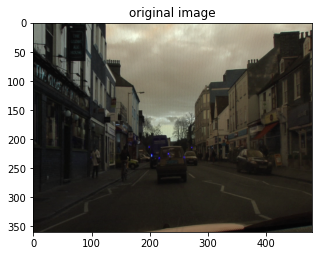

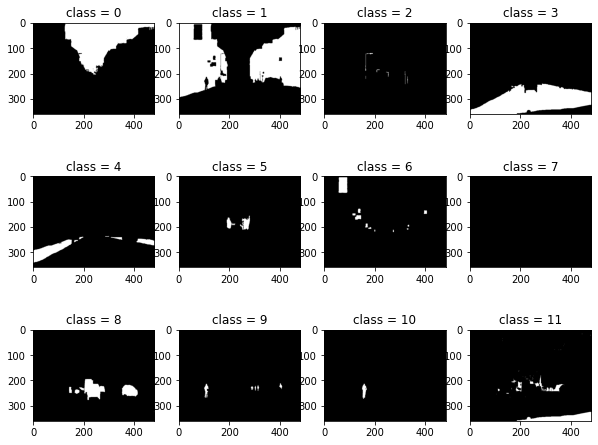

In [7]:
ldseg = np.array(os.listdir(dir_seg))
# pick the  image from file file
fnm = ldseg[40]
print(fnm)

# read in the original image and segmentation 
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )


# Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi+1 
#print("minimum seg = ",mi)
#print( "maximum seg = ",ma)
print("Total number of segmentation classes = ",n_classes)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()
fig = plt.figure(figsize=(10,8))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("class = {}".format(k))


plt.show()
sns.set_style("whitegrid", {'axes.grid' : False})

# Resizing of single images (224,224)

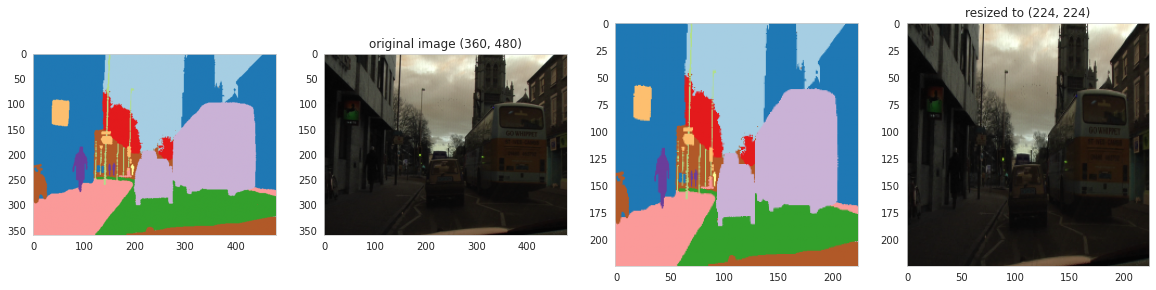

In [8]:
def give_color_to_seg_img(seg,n_classes):
        #seg : (input_width,input_height,3)
       
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    
    #colors = sns.color_palette(['black','green','blue','yellow','red','magenta','orange','pink','brown','purple','gray'], n_classes)#Paired, colorblind, hls
    colors = sns.color_palette('Paired', n_classes)#Paired, colorblind, hls
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),1,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

# Resizing all the 701 images in the dataset to (224,224)
 

In [9]:
print("Resizing all the image, this may take some minutes, please wait....\n")


def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
   
    return seg_labels

images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)
print("\n Resizing completed..")

Resizing all the image, this may take some minutes, please wait....

(701, 224, 224, 3) (701, 224, 224, 12)

 Resizing completed..


# Creating model

DownSampling
1. The contracting path is composed of 5 blocks: 
2. Three convolution layer of size 1x1, 3x3, and 5x5 + activation function
2x2 Max Pooling
3. Note that the number of feature maps doubles at each pooling, starting with 64 feature maps for the first block, 128 for the second, and so on.

BottleNeck
1. The bottleneck is built from simply 2 convolutional layers (with batch normalization), with dropout.

Upsampling
1. The expanding path is also composed of 5 blocks :
2. Upsampling  block
3. Concatenation with the corresponding feature map from the contracting path
4. Two 3x3 Convolution layer + activation function
5. The purpose of this expanding path is to enable precise localization combined with contextual information from the contracting path.



In [10]:
#Main model


from keras.initializers import glorot_uniform
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import os
from tensorflow.python.keras.layers import Input, Conv2D,Dropout,MaxPooling2D,Lambda,Conv2DTranspose
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers.merge import concatenate as Concatenate
from tensorflow.python.keras import Model
import numpy as np
import tensorflow as tf

def check_model(nClasses ,  input_height=224, input_width=224):
    

    img_input = Input(shape=(input_height,input_width,3))
    
    conv1= Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(img_input)   
    #conv1= Dropout(0.1)(conv1)
    conv1a= Conv2D(32,(1,1),  activation='relu', kernel_initializer="he_normal",padding="same")(conv1)
    conv1b= Conv2D(32,(3,3), activation='relu', kernel_initializer="he_normal",padding="same")(conv1)
    conv1c= Conv2D(32, (5,5), activation='relu', kernel_initializer="he_normal", padding="same")(conv1)
    c1=Concatenate([conv1a,conv1b,conv1c])
    p1=MaxPooling2D((2,2))(c1)

    conv2=Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p1)
    #conv2=Dropout(0.1)(conv2)
    conv2a = Conv2D(64, (1,1), activation='relu', kernel_initializer="he_normal", padding="same")(conv2)
    conv2b = Conv2D(64, (3,3), activation='relu', kernel_initializer="he_normal", padding="same")(conv2)
    conv2c = Conv2D(64, (5, 5), activation='relu', kernel_initializer="he_normal", padding="same")(conv2)
    c2 = Concatenate([conv2a,conv2b,conv2c])
    p2=MaxPooling2D((2,2))(c2)

    conv3= Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p2)
    #conv3= Dropout(0.1)(conv3)
    conv3a = Conv2D(128, (1,1), activation='relu', kernel_initializer="he_normal", padding="same")(conv3)
    conv3b = Conv2D(128, (3,3), activation='relu', kernel_initializer="he_normal", padding="same")(conv3)
    conv3c = Conv2D(128, (5, 5), activation='relu', kernel_initializer="he_normal", padding="same")(conv3)
    c3 = Concatenate([conv3a,conv3b,conv3c])
    p3=MaxPooling2D((2,2))(c3)

    conv4= Conv2D(512,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p3)
    conv4= Dropout(0.5)(conv4)
    conv4a = Conv2D(256, (1,1), activation='relu', kernel_initializer="he_normal", padding="same")(conv4)
    conv4b = Conv2D(256, (3,3), activation='relu', kernel_initializer="he_normal", padding="same")(conv4)
    conv4c = Conv2D(256, (5, 5),activation='relu', kernel_initializer="he_normal", padding="same")(conv4)
    c4 = Concatenate([conv4a,conv4b,conv4c])
    p4=MaxPooling2D((2,2))(c4)

    #extra
    
    conv5= Conv2D(512,(3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p4)
    conv5= Dropout(0.5)(conv5)
    conv5a = Conv2D(256, (1,1), activation='relu', kernel_initializer="he_normal", padding="same")(conv5)
    conv5b = Conv2D(256, (3,3), activation='relu', kernel_initializer="he_normal", padding="same")(conv5)
    conv5c = Conv2D(256, (5, 5),activation='relu', kernel_initializer="he_normal", padding="same")(conv5)
    
    c5 = Concatenate([conv5a,conv5b,conv5c])
    p4=MaxPooling2D((2,2))(c5)


    conv5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    conv5 = Dropout(0.4)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    print("\n Build encoder done..")

  #extra
    
    #u7 = (UpSampling2D( (2,2), data_format='channels_last'))(conv5)
    u5=Conv2DTranspose(512,(2,2),strides=(2,2),activation="relu", kernel_initializer="he_normal", padding="same")(conv5)
    u5=Concatenate([u5,c5])
    c55a=Conv2D(512,(3,3), activation="relu",kernel_initializer="he_normal",padding="same")(u5)
    c55b=Dropout(0.1)(c55a)
    c55c=Conv2D(512, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c55b)


    #u6 = (UpSampling2D( (2,2), data_format='channels_last'))(c5)
    u6=Conv2DTranspose(512,(2,2),strides=(2,2),activation="relu", kernel_initializer="he_normal", padding="same")(c55c)
    u6=Concatenate([u6,c4])
    c6=Conv2D(512,(3,3), activation="relu",kernel_initializer="he_normal",padding="same")(u6)
    c6=Dropout(0.1)(c6)
    c6=Conv2D(512, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c6)

    #u7=(UpSampling2D( (2,2), data_format='channels_last'))(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    #u8=(UpSampling2D( (2,2), data_format='channels_last'))(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    #u9=(UpSampling2D( (2,2), data_format='channels_last'))(c8)


    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
   
    
    outputs=Conv2D(nClasses,(1,1), activation='softmax', name='output')(c9)

    model=Model(img_input , outputs)
    print("\n Build decoder done..")
    return model

In [11]:
model = check_model(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()


 Build encoder done..

 Build decoder done..
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 2080        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 18464       conv2d[0][0]                     
________________________________________________

In [ ]:
#class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 0.6823, 6.2478, 7.3614, 1.0974]

PNET Model acrchitecture

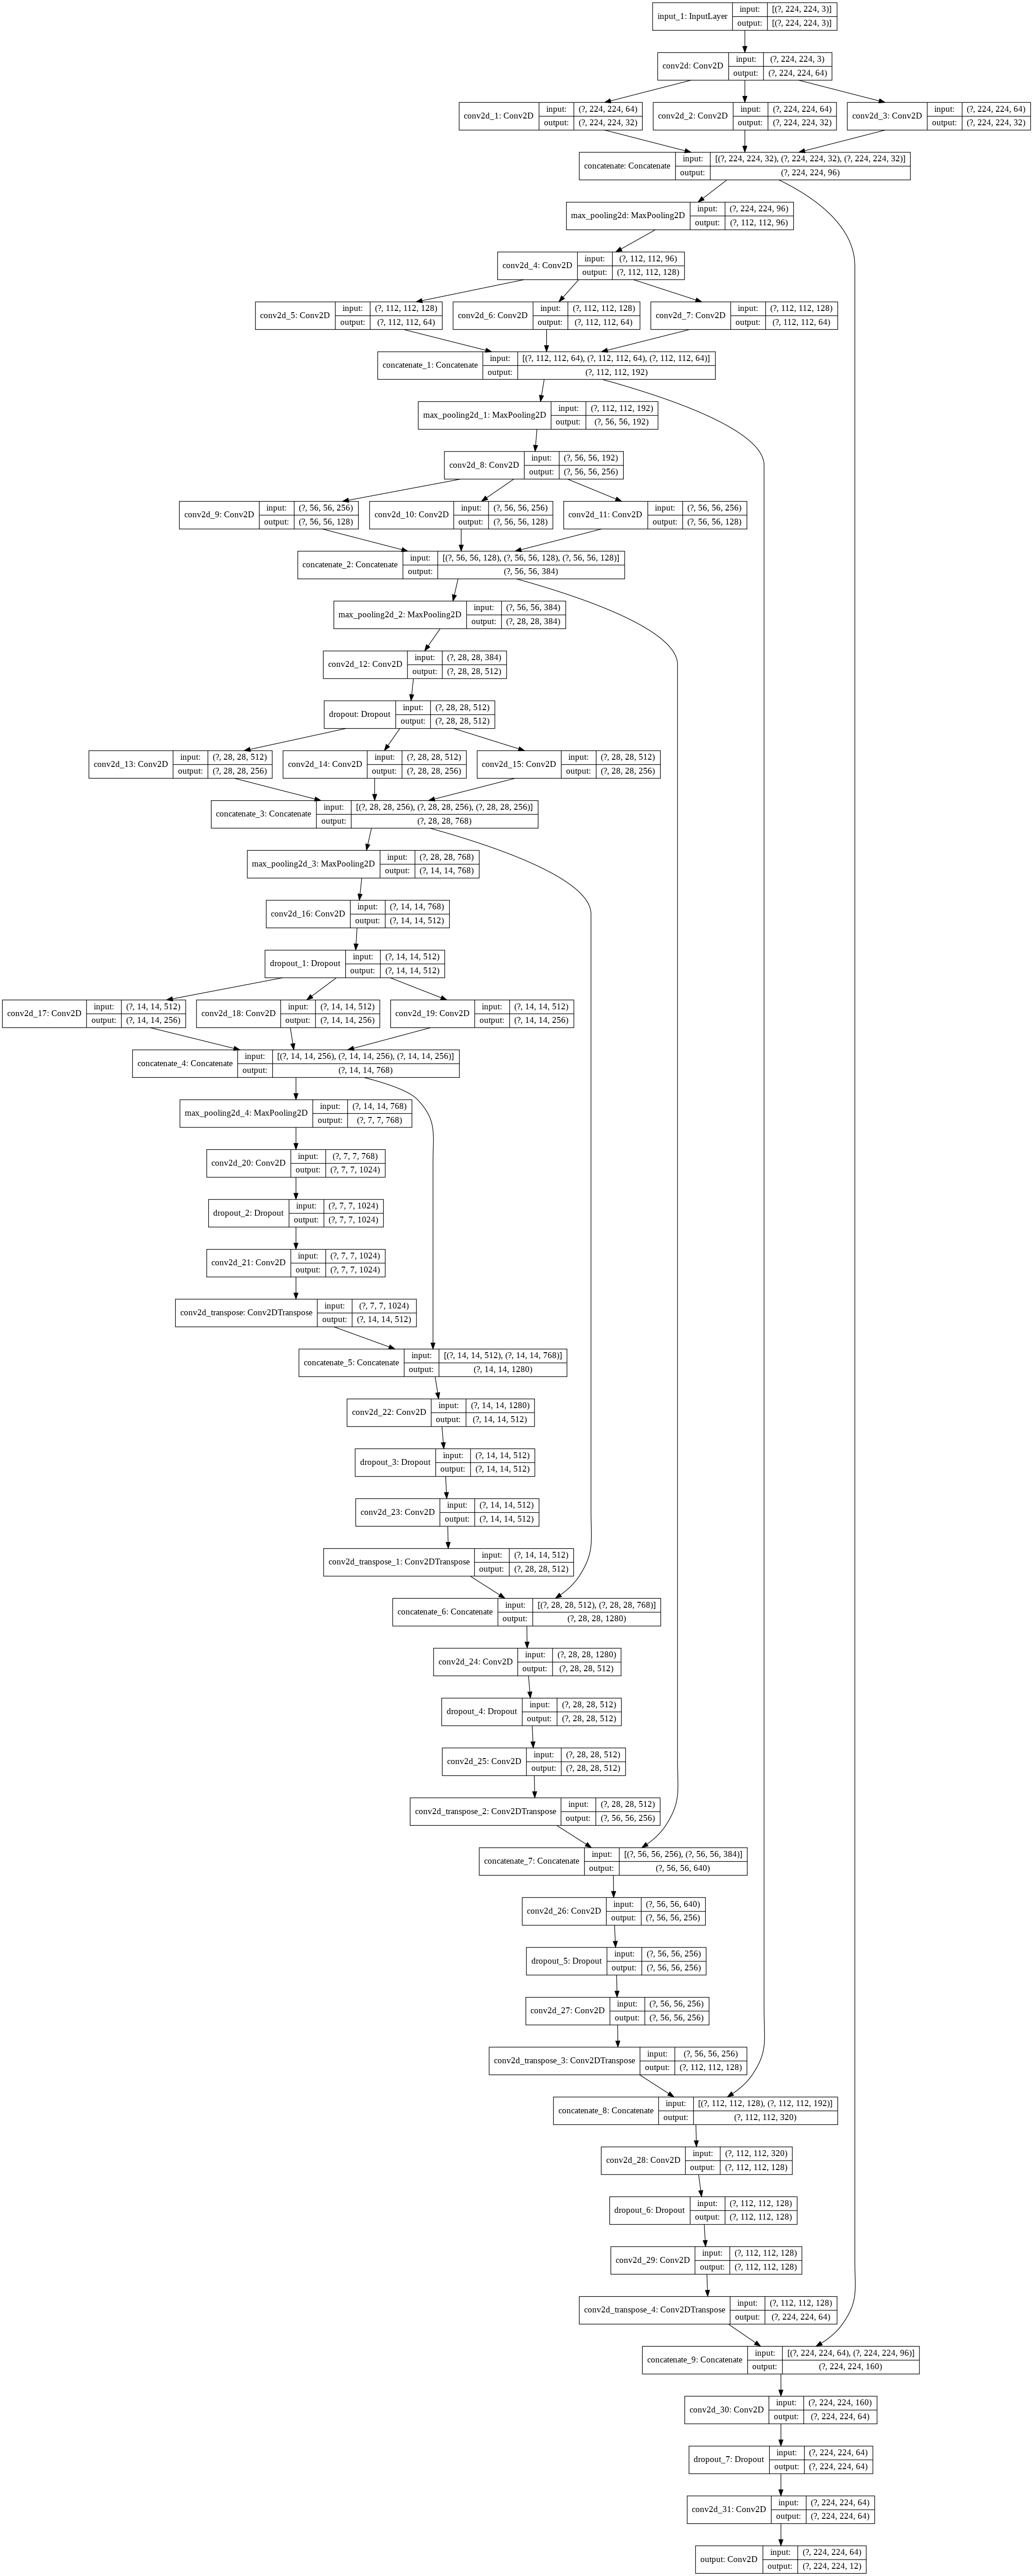

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Split for training and testing data

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(595, 224, 224, 3) (595, 224, 224, 12)
(106, 224, 224, 3) (106, 224, 224, 12)


Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [ ]:

from tensorflow.keras.optimizers import Adam, Adadelta, Adamax, Nadam, Ftrl

In [ ]:
#mean iou to be use in model.compile 
def mean_iou(y_true, y_pred):
    
    prec=[]
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_=tf.to_int32(y_pred>t)
        score, up_opt=tf.metrics.mean_iou(y_true,y_pred_,2)  # label, pred, num_classes
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]): # up_opt를 먼저 실행하고 with 아래의 문장을 실행
            score=tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec),axis=0)


In [ ]:
def mean_iou_loss(y_true, y_pred):
    return 1.-mean_iou(y_true, y_pred)


In [ ]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)


In [ ]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [ ]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='/content/drive/My Drive/camvidlatest/camvid_model_150_epochs_checkpoint.h5', monitor='val_acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_loss', patience=90, verbose=1)
callbacks = [tb, mc, es]

### Model training

In [ ]:
from keras import optimizers

model.compile(loss= 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32, 
                  epochs=100, 
                  verbose=1,
                  callbacks=callbacks)
                 
                  
                 # )  callbacks=callbacks
#model.save_weights("/content/drive/My Drive/camvidlatest/camvid_model_150_epochs.h5", overwrite=True)
model.save("/content/drive/My Drive/camvidlatest/camvid_model_150_epochs.h5", overwrite=True)     #this save everything about thfe model so that wecan use it later

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 595 samples, validate on 106 samples
Epoch 1/100
576/595 [============================>.] - ETA: 0s - loss: 1.5875 - acc: 0.5369
Epoch 00001: val_acc improved from -inf to 0.27667, saving model to /content/drive/My Drive/camvidlatest/camvid_model_150_epochs_checkpoint.h5
595/595 [==============================] - 40s 68ms/sample - loss: 1.5714 - acc: 0.5414 - val_loss: 11.6541 - val_acc: 0.2767
Epoch 2/100
576/595 [============================>.] - ETA: 0s - loss: 1.0342 - acc: 0.6790
Epoch 00002: val_acc improved from 0.27667 to 0.31611, saving model to /content/drive/My Drive/camvidlatest/camvid_model_150_epochs_checkpoint.h5
595/595 [==============================] - 20s 34ms/sample - loss: 1.0321 - acc: 0.6801 - val_loss: 3.6885 - val_acc: 0.3161
Epoch 3/100
576/595 [============================>.] - ETA: 0s - loss: 0.9601 - acc: 0.7004
Epoch 00003: val_acc improved from 0.31611 t

In [ ]:
#Saving the weight of the trained model
model.save("/content/drive/My Drive/camvidlatest/camvid_model_150_epochs.h5", overwrite=True) 

Visualizing Model Training and Accuracy using graph

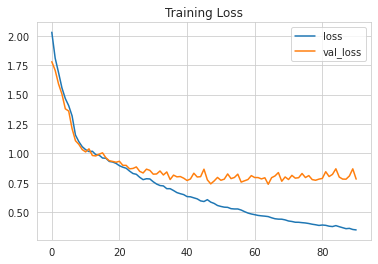

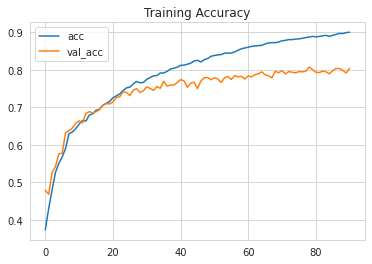

In [ ]:

plt.title("Training Loss")
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

plt.title("Training Accuracy")
for i in ['acc', 'val_acc']:
    plt.plot(hist1.history[i],label=i)
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(106, 224, 224) (106, 224, 224)


Train and Test Accuracy with loss percent

In [ ]:
hist1= model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', hist1[0])
print('Test accuracy:' , hist1[1])
_, accuracy = model.evaluate(X_test,y_test, verbose=0)
print('Test Accuracy: %.2f' % (accuracy*100))

Test loss: 0.7869410166200602
Test accuracy: 0.8335478
Test Accuracy: 83.35


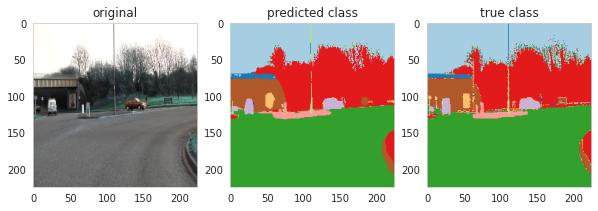

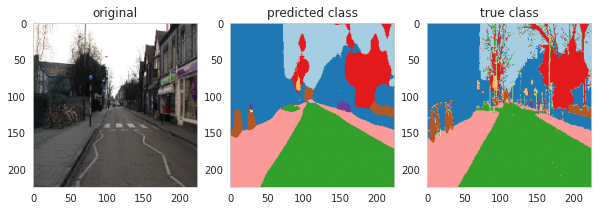

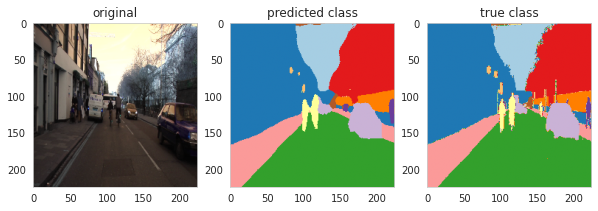

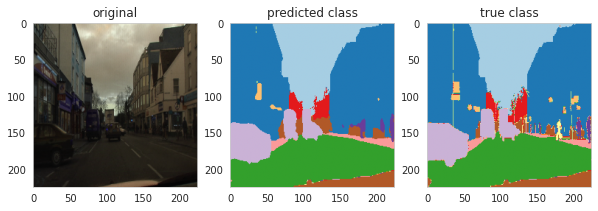

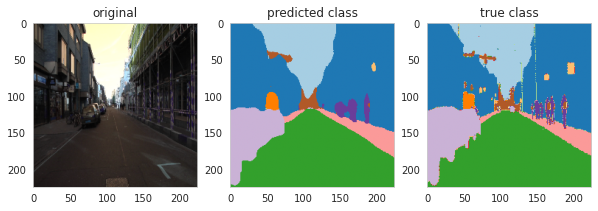

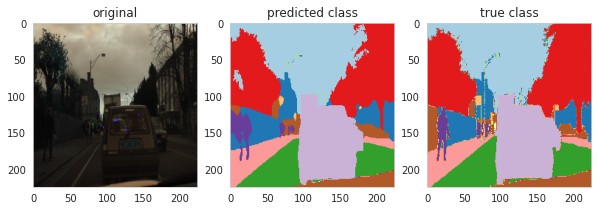

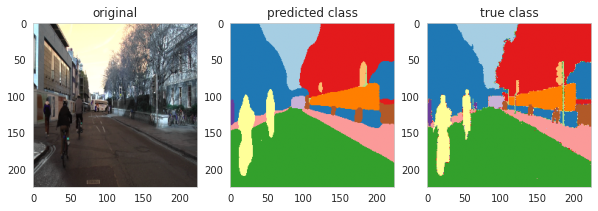

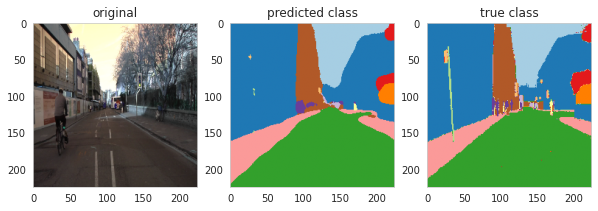

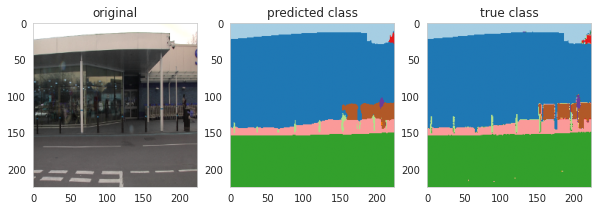

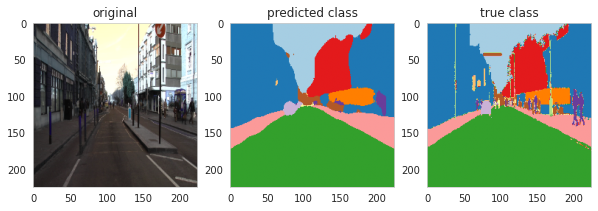

In [ ]:
shape = (224,224)
n_classes= 12

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()

In [ ]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f},  #FP={:6.0f},  #FN={:5.0f},  IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("--------------------------------------")
    print("Mean IoU: {:4.3f}".format(mIoU))
    print("Mean IoU: {:4.2f}%".format(mIoU*100))
    
IoU(y_testi,y_predi)



class 00: #TP=761443,  #FP= 99833,  #FN=84132,  IoU=0.805
class 01: #TP=1211127,  #FP=333553,  #FN=136885,  IoU=0.720
class 02: #TP=  4938,  #FP= 10082,  #FN=51872,  IoU=0.074
class 03: #TP=1369296,  #FP= 56776,  #FN=100017,  IoU=0.897
class 04: #TP=311142,  #FP=122023,  #FN=74869,  IoU=0.612
class 05: #TP=438947,  #FP= 87671,  #FN=141188,  IoU=0.657
class 06: #TP= 10720,  #FP=  8974,  #FN=45878,  IoU=0.163
class 07: #TP= 31754,  #FP= 19455,  #FN=34139,  IoU=0.372
class 08: #TP=172087,  #FP= 40316,  #FN=85747,  IoU=0.577
class 09: #TP= 11268,  #FP= 23776,  #FN=31791,  IoU=0.169
class 10: #TP= 11559,  #FP=  5974,  #FN=20045,  IoU=0.308
class 11: #TP= 99073,  #FP= 76869,  #FN=78739,  IoU=0.389
--------------------------------------
Mean IoU: 0.479
Mean IoU: 47.87%


In [ ]:
#dice score should not me greater then 1
def dice(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        dice = 2*TP/float((TP + FP + FN)+TP)   # 2* intersection / union + intersection   or 2* (intrsection of segmented truth ground truth) /segmented truth + ground truth
        print("class {:02.0f}: #TP={:6.0f},  #FP={:6.0f},  #FN={:5.0f},  Dice={:4.3f}".format(c,TP,FP,FN,dice))
        #dice.append(dice)
    Mean_dice = np.mean(dice)
    print("---------------------------------------")
    print("Average Dice_coef: {:4.3f}".format(Mean_dice))
    print("Average Dice_coef: {:4.2f}%".format(Mean_dice*100))
    
dice(y_testi,y_predi)





class 00: #TP=761443,  #FP= 99833,  #FN=84132,  Dice=0.892
class 01: #TP=1211127,  #FP=333553,  #FN=136885,  Dice=0.837
class 02: #TP=  4938,  #FP= 10082,  #FN=51872,  Dice=0.137
class 03: #TP=1369296,  #FP= 56776,  #FN=100017,  Dice=0.946
class 04: #TP=311142,  #FP=122023,  #FN=74869,  Dice=0.760
class 05: #TP=438947,  #FP= 87671,  #FN=141188,  Dice=0.793
class 06: #TP= 10720,  #FP=  8974,  #FN=45878,  Dice=0.281
class 07: #TP= 31754,  #FP= 19455,  #FN=34139,  Dice=0.542
class 08: #TP=172087,  #FP= 40316,  #FN=85747,  Dice=0.732
class 09: #TP= 11268,  #FP= 23776,  #FN=31791,  Dice=0.289
class 10: #TP= 11559,  #FP=  5974,  #FN=20045,  Dice=0.470
class 11: #TP= 99073,  #FP= 76869,  #FN=78739,  Dice=0.560
---------------------------------------
Average Dice_coef: 0.560
Average Dice_coef: 56.01%


# 2nd iteration to Improve accuarcy of the model

---


In [ ]:
from sklearn.utils import shuffle
train_rate = 0.9
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(630, 224, 224, 3) (630, 224, 224, 12)
(71, 224, 224, 3) (71, 224, 224, 12)


In [ ]:
#saved model can be loaded as below so that we dont have to train our model again and again
from tensorflow import keras
from keras.models import load_model

new_model = keras.models.load_model("/content/drive/My Drive/camvidlatest/camvid_model_150_epochs.h5")
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 2080        batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#model Weight Saving 
new_model.save("/content/drive/My Drive/camvidlatest/camvid_model_150_epochs.h5", overwrite=True) 
print("Saving completed")

Saving completed


In [ ]:
y_pred = new_model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)


In [ ]:
#for new model saved
hist1= new_model.evaluate(X_test,y_test, verbose=0)
print('Restored Test loss:', hist1[0])
print('Restored Test accuracy:' , hist1[1])
_, accuracy = new_model.evaluate(X_test,y_test, verbose=0)
print('Restored Test Accuracy: %.2f' % (accuracy*100))

Restored Test loss: 0.34857711336191965
Restored Test accuracy: 0.9122613
Restored Test Accuracy: 91.23


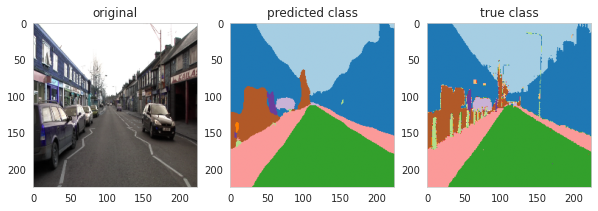

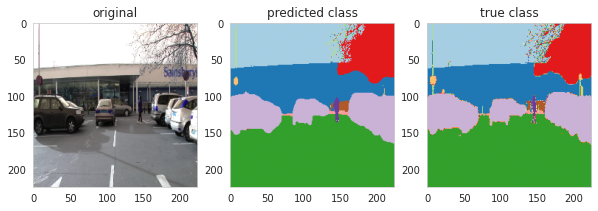

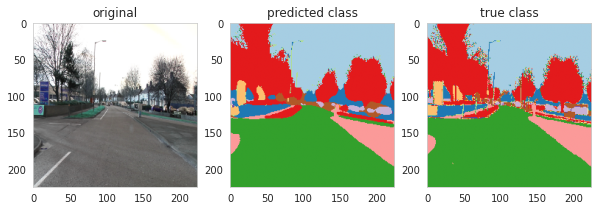

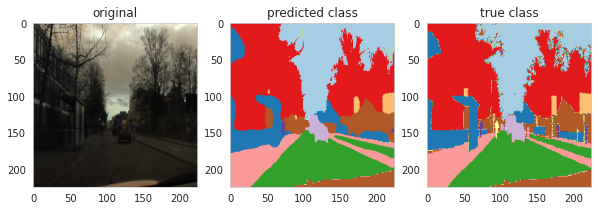

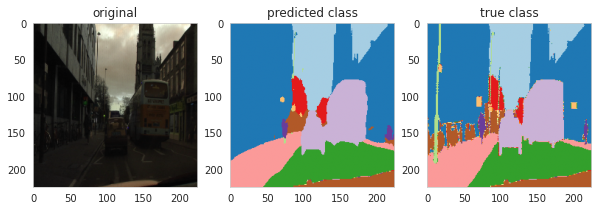

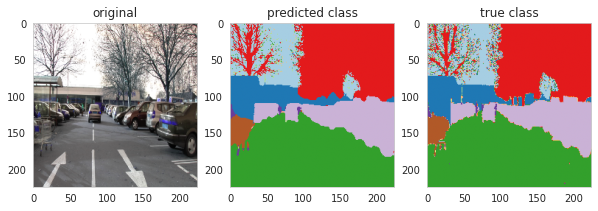

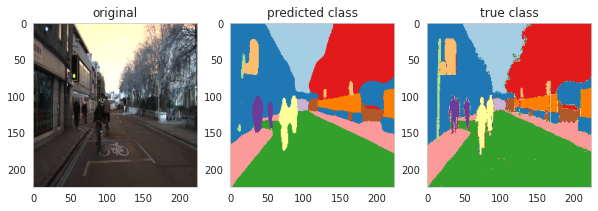

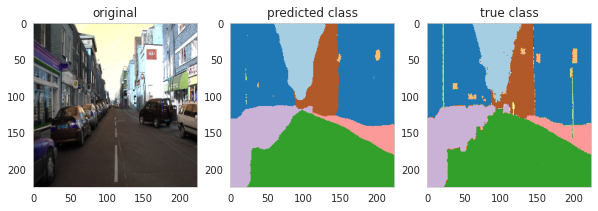

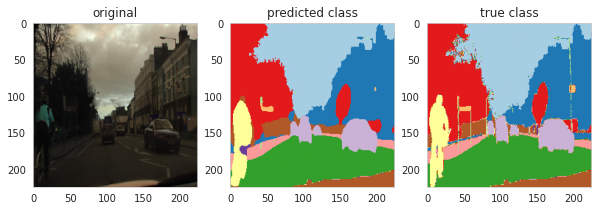

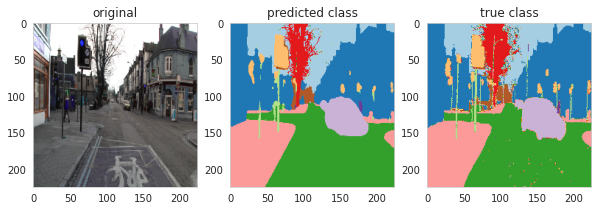

In [ ]:
shape = (224,224)
n_classes= 12

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()

In [ ]:
#Restored MIoU
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f},  #FP={:6.0f},  #FN={:5.0f},  IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("----------------------------------------------------------")
    print("Mean IoU: {:4.3f}".format(mIoU))
    print("Mean IoU: {:4.2f}%".format(mIoU*100))
    
IoU(y_testi,y_predi)

class 00: #TP=750698,  #FP= 56107,  #FN=19058,  IoU=0.909
class 01: #TP=1297448,  #FP=108813,  #FN=42054,  IoU=0.896
class 02: #TP= 11057,  #FP= 10585,  #FN=53171,  IoU=0.148
class 03: #TP=1534546,  #FP= 18393,  #FN=64853,  IoU=0.949
class 04: #TP=321328,  #FP= 58028,  #FN=33362,  IoU=0.779
class 05: #TP=527610,  #FP= 45107,  #FN=44725,  IoU=0.855
class 06: #TP= 39117,  #FP=  7554,  #FN=29888,  IoU=0.511
class 07: #TP= 56628,  #FP= 10024,  #FN=13620,  IoU=0.705
class 08: #TP=236813,  #FP= 16853,  #FN=26943,  IoU=0.844
class 09: #TP= 17568,  #FP= 10912,  #FN=18605,  IoU=0.373
class 10: #TP= 26611,  #FP=  6595,  #FN=13322,  IoU=0.572
class 11: #TP=117283,  #FP= 32978,  #FN=22348,  IoU=0.679
----------------------------------------------------------
Mean IoU: 0.685
Mean IoU: 68.49%


In [ ]:
#Restoed Dice score
#dice score should not me greater then 1
def dice(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        dice = 2*TP/float((TP + FP + FN)+TP)   # 2* intersection / union + intersection   or 2* (intrsection of segmented truth ground truth) /segmented truth + ground truth
        print("class {:02.0f}: #TP={:6.0f},  #FP={:6.0f},  #FN={:5.0f},  Dice={:4.3f}".format(c,TP,FP,FN,dice))
        #dice.append(dice)
    Mean_dice = np.mean(dice)
    print("-------------------------------------------------")
    print("Average Dice_coef: {:4.3f}".format(Mean_dice))
    print("Average Dice_coef: {:4.2f}%".format(Mean_dice*100))
    
dice(y_testi,y_predi)


class 00: #TP=750698,  #FP= 56107,  #FN=19058,  Dice=0.952
class 01: #TP=1297448,  #FP=108813,  #FN=42054,  Dice=0.945
class 02: #TP= 11057,  #FP= 10585,  #FN=53171,  Dice=0.258
class 03: #TP=1534546,  #FP= 18393,  #FN=64853,  Dice=0.974
class 04: #TP=321328,  #FP= 58028,  #FN=33362,  Dice=0.875
class 05: #TP=527610,  #FP= 45107,  #FN=44725,  Dice=0.922
class 06: #TP= 39117,  #FP=  7554,  #FN=29888,  Dice=0.676
class 07: #TP= 56628,  #FP= 10024,  #FN=13620,  Dice=0.827
class 08: #TP=236813,  #FP= 16853,  #FN=26943,  Dice=0.915
class 09: #TP= 17568,  #FP= 10912,  #FN=18605,  Dice=0.543
class 10: #TP= 26611,  #FP=  6595,  #FN=13322,  Dice=0.728
class 11: #TP=117283,  #FP= 32978,  #FN=22348,  Dice=0.809
-------------------------------------------------
Average Dice_coef: 0.809
Average Dice_coef: 80.91%
